# 4.1. Using the `Network` object: Accessing data

Available as a jupyter notebook or wiki page.

Let's read in a sample MATSim network into GeNet's `Network` object.

In [1]:
import os

from genet import read_matsim

path_to_matsim_network = "example_data/pt2matsim_network"

network = os.path.join(path_to_matsim_network, "network.xml")
schedule = os.path.join(path_to_matsim_network, "schedule.xml")
vehicles = os.path.join(path_to_matsim_network, "vehicles.xml")
n = read_matsim(
    path_to_network=network, epsg="epsg:27700", path_to_schedule=schedule, path_to_vehicles=vehicles
)
# # you don't need to read the vehicles file, but doing so ensures all vehicles
# # in the schedule are of the expected type and the definition of the vehicle
# # is preserved

n.print()

Graph info: MultiDiGraph with 1662 nodes and 3166 edges 
Schedule info: Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 118


## Summary

The network summary report can be accessed using the `summary_report` method

In [2]:
n.summary_report()

2023-09-22 16:38:59,166 - Creating a summary report


{'network': {'network_graph_info': {'Number of network links': 1662,
   'Number of network nodes': 3166},
  'modes': {'Modes on network links': {'artificial', 'bus', 'car', 'pt'},
   'Number of links by mode': {'bus': 182,
    'pt': 153,
    'car': 3161,
    'artificial': 3}},
  'osm_highway_tags': {'Number of links by tag': {'secondary_link': 2,
    'tertiary_link': 2,
    'unclassified': 1027,
    'residential': 758,
    'trunk': 213,
    'secondary': 185,
    'tertiary': 326,
    'trunk_link': 17,
    'primary_link': 5,
    'primary': 619,
    'living_street': 7,
    'service': 2}}},
 'schedule': {'schedule_info': {'Number of services': 9,
   'Number of routes': 68,
   'Number of stops': 118},
  'modes': {'Modes in schedule': {'bus'},
   'Services by mode': {'bus': 9},
   'PT stops by mode': {'bus': 45}},
  'accessibility_tags': {'Stops with tag bikeAccessible': 0,
   'Unique values for bikeAccessible tag': set(),
   'Stops with tag carAccessible': 0,
   'Unique values for carAccess


The data saved on the edges or nodes of the graph can be nested. There are a couple of convenient methods that summarise the schema of the data found on the nodes and links. If `data=True`, the output also shows up to 5 unique values stored in that location.

In [3]:
n.node_attribute_summary(data=True)

attribute
├── id: ['11544697', '104315', '1678452811', '311422343', '469760241']
├── x: [528387.4250512555, 528391.4406755936, 528393.2742107178, 528396.6287644263, 528396.3513181042]
├── y: [181547.5850354673, 181552.72935927223, 181558.10532352765, 181559.970402835, 181562.0370527053]
├── lon: [-0.15158899257367864, -0.12442822565449774, -0.15899252175318956, -0.15361283930874237, -0.12577980091961471]
├── lat: [51.52460173698216, 51.524373271398304, 51.527495850386345, 51.51479865999261, 51.524347848546434]
└── s2_id: [5221390806708822025, 5221390277485711373, 5221390713080987667, 5221390309038805015, 5221390757749727255]


In [4]:
n.link_attribute_summary(data=False)

attribute
├── id
├── from
├── to
├── freespeed
├── capacity
├── permlanes
├── oneway
├── modes
├── s2_from
├── s2_to
├── attributes
│   ├── osm:way:access
│   ├── osm:way:highway
│   ├── osm:way:id
│   ├── osm:way:name
│   ├── osm:relation:route
│   ├── osm:way:lanes
│   ├── osm:way:oneway
│   ├── osm:way:tunnel
│   ├── osm:way:psv
│   ├── osm:way:vehicle
│   ├── osm:way:traffic_calming
│   ├── osm:way:junction
│   └── osm:way:service
└── length


Once you see the general schema for the data stored on nodes and links, you may decide to look at or perform analysis 
on all of the data stored in the netowrk under a particular key. A GeNet network has two methods which generate a
`pandas.Series` object, which stores the nodes or links data present at the specified key, indexed by the same index 
as the nodes or links.

In [5]:
s2_id = n.node_attribute_data_under_key("s2_id")

In [6]:
s2_id

101982       5221390329375415267
101986       5221390328605541517
101990       5221390304444353919
101991       5221390303990102293
101992       5221390304897701221
                    ...         
983839058    5221390693831743163
99936        5221390299301007353
99937        5221390299484518181
99940        5221390294354288325
99943        5221390298004709849
Length: 1662, dtype: int64

In [7]:
n.link_attribute_data_under_key("freespeed").head()

1       4.166667
10      4.166667
100     4.166667
1000    4.166667
1001    4.166667
dtype: float64

Or you can access nested data,

In [8]:
n.link_attribute_data_under_key({"attributes": "osm:way:lanes"}).head()

1007    2
1008    2
1037    2
1038    2
1039    2
dtype: object

You can also build a `pandas.DataFrame` out of several keys.

In [9]:
n.link_attribute_data_under_keys(["freespeed", {"attributes": "osm:way:highway"}]).head()

,freespeed,attributes::osm:way:highway
1,4.166667,unclassified
10,4.166667,unclassified
100,4.166667,unclassified
1000,4.166667,residential
1001,4.166667,residential


## Extracting links of interest

The function below gathers link ids which satisfy conditions 
to arbitrary level of nested-ness. It also allows quite flexible conditions---below we require that the link value
at `data['attributes']['osm:way:highway'] == 'primary'`, where data is the data dictionary stored on that link.

In [10]:
links = n.extract_links_on_edge_attributes(
    conditions={"attributes": {"osm:way:highway": "primary"}}
)

In [11]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [12]:
len(links)

619

Note, it is possible to set data in long format, specifying the JAVA class of the data stored, i.e.
```
{'id': '1007',
 'from': '4356572310',
 'to': '5811263955',
 'attributes': {'osm:way:highway': {'name': 'osm:way:highway',
   'class': 'java.lang.String',
   'text': 'primary'},
  'osm:way:id': {'name': 'osm:way:id',
   'class': 'java.lang.Long',
   'text': '589660342'},
  'osm:way:lanes': {'name': 'osm:way:highway',
   'class': 'java.lang.String',
   'text': 'primary'},
  'osm:way:name': {'name': 'osm:way:name',
   'class': 'java.lang.String',
   'text': 'Shaftesbury Avenue'},
  'osm:way:oneway': {'name': 'osm:way:oneway',
   'class': 'java.lang.String',
   'text': 'yes'}},
 'length': 13.941905154249884}
```
This is useful if you want to force the data to be saved to MATSim XML file with that specific data type.

In that case, to find primary highway links, you would instead set the following condition:
```python
links = n.extract_links_on_edge_attributes(
    conditions= {'attributes': {'osm:way:highway': {'text': 'primary'}}},
)
```

Below we now require that the link value
at `data['attributes']['osm:way:highway'] in ['primary', 'something else']`. There is nothing in the data that has such tags, so the output is the same.

In [13]:
links = n.extract_links_on_edge_attributes(
    conditions={"attributes": {"osm:way:highway": ["primary", "something else"]}}
)

In [14]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [15]:
len(links)

619

We can also pass a list of conditions. In this case it makes sense for us to specify how multiple conditions should be handled. We can do it via 
- `how=all` - all conditions need to be met
- `how=any` - at least one condition needs to be met

It is set to `any` as default.

In [16]:
links = n.extract_links_on_edge_attributes(
    conditions=[
        {"attributes": {"osm:way:highway": "primary"}},
        {"attributes": {"osm:way:highway": "something else"}},
    ],
    how=any,
)

In [17]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [18]:
len(links)

619

In [19]:
links = n.extract_links_on_edge_attributes(
    conditions=[
        {"attributes": {"osm:way:highway": "primary"}},
        {"attributes": {"osm:way:highway": "something else"}},
    ],
    how=all,
)

In [20]:
links[:5]

[]

As expected, no links satisfy both `data['attributes']['osm:way:highway'] == 'primary'` and `data['attributes']['osm:way:highway'] == 'something else'`.

Below, we give an example of subsetting a numeric boundary. We find links where `0 <= 'freespeed'  <= 20`.

In [21]:
links = n.extract_links_on_edge_attributes(conditions={"freespeed": (0, 20)})

In [22]:
links[:5]

['1', '10', '100', '1000', '1001']

In [23]:
len(links)

2334

Finally, we can define a function that will handle the condition for us. The function should take the value expected at the key in the data dictionary and return either `True` or `False`.

For example, below we give an example equivalent to our first example of `data['attributes']['osm:way:highway']['text'] == 'primary'` but using a function we defined ourselves to handle the condition.

In [24]:
def highway_primary(value):
    return value == "primary"


links = n.extract_links_on_edge_attributes(
    conditions={"attributes": {"osm:way:highway": highway_primary}}
)

In [25]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [26]:
len(links)

619

This allows for really flexible subsetting of the network based on data stored on the edges. Another example, similar to the numeric boundary, but this time we only care about the upper bound and we make it a strict inequality.

In [27]:
def below_20(value):
    return value < 20


links = n.extract_links_on_edge_attributes(conditions={"freespeed": below_20})

In [28]:
links[:5]

['1', '10', '100', '1000', '1001']

In [29]:
len(links)

2334

### Modal convenience methods

In [30]:
n.links_on_modal_condition("bus")[:5]

['1021', '1023', '1024', '1079', '1105']

`nodes_on_modal_condition` will return nodes connected to the links satisfying the modal condition.

In [31]:
n.nodes_on_modal_condition(["car", "bus"])[:5]

['1678452811', '469760241', '25530033', '282688899', '21583343']

### Spatial convenience methods

For spatial extraction conditions you have a choice of:
- `shapely.geometry.Polygon` or `shapely.geometry.GeometryCollection` of Polygons (in epsg:4326)
- geojson file, can be generated with [http://geojson.io/](http://geojson.io/)
- [S2 Geometry hex string which can be generated and copied from http://s2.sidewalklabs.com/regioncoverer](http://s2.sidewalklabs.com/regioncoverer/?center=51.522960%2C-0.144245&zoom=16&cells=48761ad71%2C48761ad723%2C48761ad724c%2C48761ad73c%2C48761ad744%2C48761ad75d3%2C48761ad75d5%2C48761ad765%2C48761ad767%2C48761ad76c%2C48761ad774%2C48761ad779%2C48761ad77b%2C48761ad783%2C48761ad784c%2C48761ad7854%2C48761ad794%2C48761ad79c%2C48761ad7a4%2C48761ad7ac%2C48761ad7b1%2C48761ad7bc)


In [32]:
_ = n.to_geodataframe()
gdf_nodes, gdf_links = _["nodes"], _["links"]

In [33]:
region = "48761ad71,48761ad723,48761ad724c,48761ad73c,48761ad744,48761ad75d3,48761ad75d5,48761ad765,48761ad767,48761ad76c,48761ad774,48761ad779,48761ad77b,48761ad783,48761ad784c,48761ad7854,48761ad794,48761ad79c,48761ad7a4,48761ad7ac,48761ad7b1,48761ad7bc"
_nodes = n.nodes_on_spatial_condition(region)[:5]
len(_nodes)

5

(<Axes: >, <Axes: >)

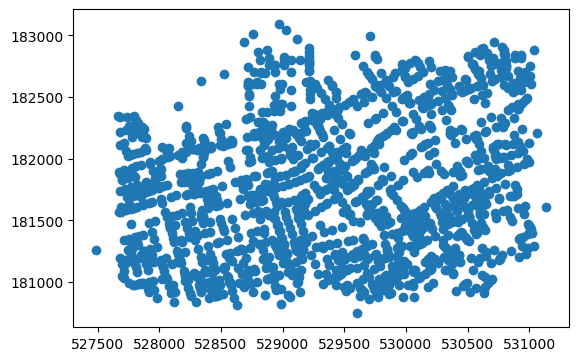

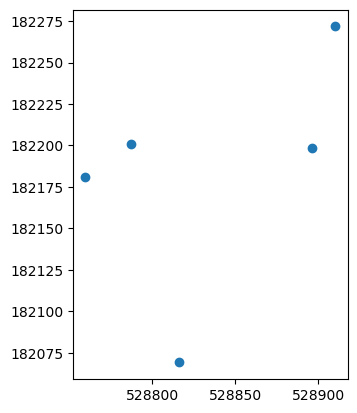

In [34]:
gdf_nodes.plot(), gdf_nodes[gdf_nodes["id"].isin(_nodes)].plot()

In [35]:
geojson = "example_data/Fitzrovia_polygon.geojson"

# here the area is too small for any routes to be within it
_links = n.links_on_spatial_condition(geojson, how="intersect")
len(_links)

/Users/bryn.pickering/mambaforge/envs/genet/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


270

(<Axes: >, <Axes: >)

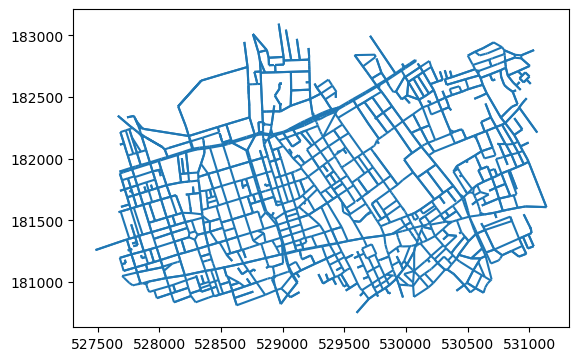

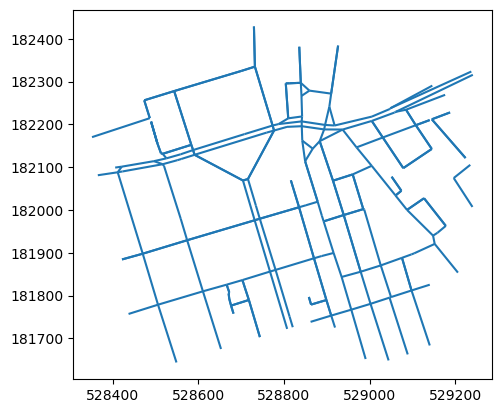

In [36]:
gdf_links.plot(), gdf_links[gdf_links["id"].isin(_links)].plot()

In [37]:
from shapely.geometry import Polygon

region = Polygon(
    [
        (-0.1487016677856445, 51.52556684350165),
        (-0.14063358306884766, 51.5255134425896),
        (-0.13865947723388672, 51.5228700191647),
        (-0.14093399047851562, 51.52006622056997),
        (-0.1492595672607422, 51.51974577545329),
        (-0.1508045196533203, 51.52276321095246),
        (-0.1487016677856445, 51.52556684350165),
    ]
)

_links = n.links_on_spatial_condition(region, how="within")
len(_links)

/Users/bryn.pickering/mambaforge/envs/genet/lib/python3.11/site-packages/shapely/predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


227

(<Axes: >, <Axes: >)

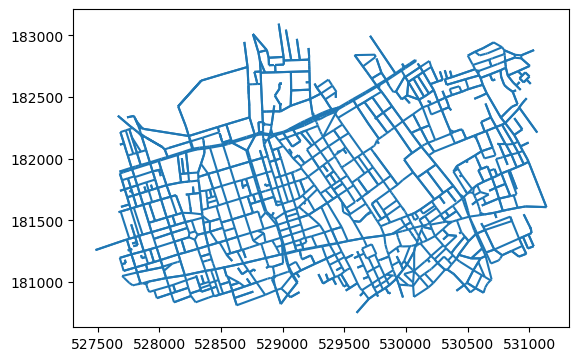

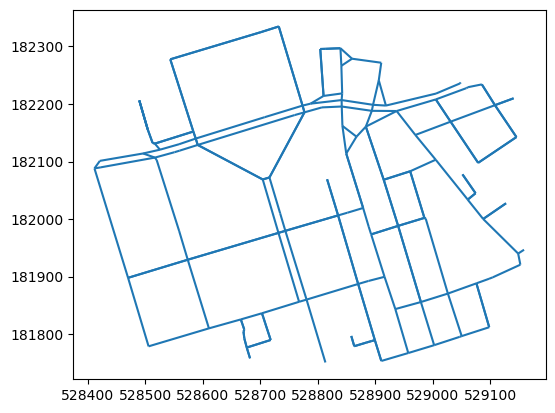

In [38]:
gdf_links.plot(), gdf_links[gdf_links["id"].isin(_links)].plot()

# Using the `Schedule` object
`Schedule` is a representation of public transit and is a part of any `genet.Network`, it is initiated as empty. A Network can exist and still be valid with an empty `Schedule`. Earlier we read a MATSim transit schedule. 

A `Schedule` is comprised of a number of nested objects. Each `Schedule` has a number of `Service`s. Each `Service` is made up a number of `Route`s. A `Route` is defined by an ordered list of `Stop` objects. Every `Service` should, logically, have at least two `Route`s, one going in one direction and another going back. Each `Route` also hold information about the trips, their timing and offsets arriving and departing at the `Stop`s.

We can look at quick stats:

In [39]:
n.schedule.print()

Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 118


Or we can plot the `Schedule` object. A `Schedule` on its' own does not have information about the `Network`, even if it has refrences to it via network routes in the `Route` objects. Thus calling a `plot` method on a Schedule will result in a plot of connections between stops for all `Route`s within all `Service`s. To plot the network routes of the `Schedule` we use the `plot` method for the `Network` object which holds that `Schedule`.

In [40]:
# n.schedule.plot()

## Summary
Schedules can get large and complicated. GeNet includes methods similar to ones presented for `Network` objects. This time, instead of inspecting data stored on links and edges of a graph, we summarise data held for Stops, Routes and Services in the Schedule.

In [41]:
n.schedule.stop_attribute_summary(data=False)

attribute
├── services
├── routes
├── id
├── x
├── y
├── epsg
├── name
├── lon
├── lat
├── s2_id
├── linkRefId
├── isBlocking
└── stopAreaId


In [42]:
n.schedule.route_attribute_summary(data=True)

attribute
├── route_short_name: ['N8', '94', '98', '205', 'N55']
├── mode: ['bus']
├── arrival_offsets: ['00:06:40', '00:06:25', '00:09:00', '00:02:49', '00:04:28']
├── departure_offsets: ['00:06:40', '00:06:25', '00:09:00', '00:02:49', '00:04:28']
├── route_long_name: ['']
├── id: ['VJ9b58a59e3d74941586a5bca7726a8aa624da67fc', 'VJ0cb60de3ed229c1413abac506e770b6ab8a7c49a', 'VJdbc280077e505b4f8d66586ca51751a125cb4ef0', 'VJ0f3c08222de16c2e278be0a1bf0f9ea47370774e', 'VJ887921c00645929c5402ac46592e57c368ea63a1']
├── trips
│   ├── trip_id: ['VJb50e9a7685a94c8fac0c372c21de9eb6317e935c_11:39:00', 'VJb2e4a1d3f19d1e118fb7d1c7bf5f684b852547d3_16:18:00', 'VJ88161e34afe3ad34f166a747e43194da511a5858_15:50:56', 'VJ14466a1be302911cd22d2f580db749a9a3bcc75a_24:25:00', 'VJ1fde46447526920c4fb1da62d2fe71cda687e7ac_05:52:00']
│   ├── trip_departure_time: ['16:41:00', '11:43:00', '10:35:00', '14:14:56', '12:52:40']
│   └── vehicle_id: ['veh_309_bus', 'veh_1828_bus', 'veh_1586_bus', 'veh_340_bus', 'veh_2044_

In [43]:
n.schedule.service_attribute_summary(data=True)

attribute
├── id: ['15660', '14073', '14134', '18853', '20274']
└── name: ['N8', '94', '98', '205', 'N55']


Again, similarly to `Network` objects, we can generate `pandas.DataFrame`s for chosen attributes of Stops, Routes and Services. These dataframes are indexed by the index of the object you query, i.e. Stop ID, Route ID or Service ID. During intantiation of a Schedule object, Route and Service indices are checked and forced to be unique, reindexing them as neccessary.

In [44]:
n.schedule.stop_attribute_data(keys=["lat", "lon", "name"]).head()

,lat,lon,name
490000235X.link:834,51.516687,-0.128071,Tottenham Court Road Station (Stop X)
490000235YB.link:574,51.516100,-0.134019,Oxford Street Soho Street (Stop YB)
490014214HE.link:3154,51.515925,-0.135367,Wardour Street (Stop OM)
490010689KB.link:981,51.515474,-0.139868,Great Titchfield Street Oxford Circus Station...
490000235P.link:15,51.516764,-0.128270,Tottenham Court Road Station New Oxford Stree...


In [45]:
n.schedule.route_attribute_data(keys=["route_short_name", "mode"]).head()

,route_short_name,mode
VJ375a660d47a2aa570aa20a8568012da8497ffecf,N55,bus
VJ812fad65e7fa418645b57b446f00cba573f2cdaf,N55,bus
VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e,N55,bus
VJ9b58a59e3d74941586a5bca7726a8aa624da67fc,134,bus
VJ0cb60de3ed229c1413abac506e770b6ab8a7c49a,N20,bus


In [46]:
n.schedule.service_attribute_data(keys="name", index_name="service_id").head()

,name
service_id,
20274,N55
15660,113
14073,94
14134,98
18853,N8


Each trip in the schedule has a vehicle assigned to it. By default, each trip will have a unique vehicle, but this can be changed by the user (have a look in modification notebook). Each vehicle is linked to a type. Each schedule begins with types based off of a config `genet/configs/vehicles/vehicle_definitions.yml`, the user may like to point to their own config file or set those values through the Schedule object.

In [47]:
n.schedule.vehicles["veh_2331_bus"]

{'type': 'Bus'}

In [48]:
n.schedule.vehicle_types["Bus"]["capacity"]["standingRoom"]["persons"] = 5
n.schedule.vehicle_types["Bus"]

{'capacity': {'seats': {'persons': '70'}, 'standingRoom': {'persons': 5}},
 'length': {'meter': '18.0'},
 'width': {'meter': '2.5'},
 'accessTime': {'secondsPerPerson': '0.5'},
 'egressTime': {'secondsPerPerson': '0.5'},
 'doorOperation': {'mode': 'serial'},
 'passengerCarEquivalents': {'pce': '2.8'}}

There exists a method to check that all vehicles are linked to a vehicle type which exists in the schedule.

In [49]:
n.schedule.validate_vehicle_definitions()

True

`trips_to_dataframe` is a useful method to extract all of the trips, their departures and vehicle IDs associated with the trips in the schedule. Trip ids need not be unique, route IDs provide a secondary index. Associated service IDs are also given for convenience. There is another method `set_trips_dataframe` which takes this dataframe and applies changes to all route trips based on the data in the dataframe. This means you can generate this DataFrame as shown below, manipulate trips (delete them, add new ones), change their departure times or change their vehicle ids to be shared for differnt trips, perhaps on some temporal logic and as long as the dataframe has the same schema, you can use it to set new trips in the schedule. This will appear in the changelog as a route level modify event. More info on this can be found in the Modifying Network notebook or wiki page.

In [50]:
n.schedule.trips_to_dataframe(gtfs_day="20210101").head()

,route_id,mode,service_id,trip_id,trip_departure_time,vehicle_id
0,VJ375a660d47a2aa570aa20a8568012da8497ffecf,bus,20274,VJ2cdccea96e0e3e6a53a968bcb132941415d6d7c9_04:...,2021-01-01 04:53:00,veh_2331_bus
1,VJ375a660d47a2aa570aa20a8568012da8497ffecf,bus,20274,VJ375a660d47a2aa570aa20a8568012da8497ffecf_03:...,2021-01-01 03:53:00,veh_2332_bus
2,VJ375a660d47a2aa570aa20a8568012da8497ffecf,bus,20274,VJ3b9d77d2ef200b21c8048fea5eedc2d2788a1b94_01:...,2021-01-01 01:54:00,veh_2333_bus
3,VJ375a660d47a2aa570aa20a8568012da8497ffecf,bus,20274,VJ79974c386a39426e06783650a759828438432aa4_05:...,2021-01-01 05:23:00,veh_2334_bus
4,VJ375a660d47a2aa570aa20a8568012da8497ffecf,bus,20274,VJa09c394b71031216571d813a6266c83f2d30bf0a_04:...,2021-01-01 04:23:00,veh_2335_bus


### Headways

You can generate a dataframe with headway information for all trips and services

In [51]:
n.schedule.trips_headways().head()

,route_id,mode,service_id,trip_id,trip_departure_time,vehicle_id,headway,headway_mins
0,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,bus,12430,VJ70cdcef7ccba9c599c70f89bdf8b10852e33bb04_11:...,1970-01-01 11:15:42,veh_409_bus,NaT,NaN
1,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,bus,12430,VJ126aa65811277b9774ae127ff819495441bc4e75_11:...,1970-01-01 11:24:42,veh_392_bus,0 days 00:09:00,9.0
2,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,bus,12430,VJ0d3b026c4060cd0325803e488a965a5ab91fd4c0_11:...,1970-01-01 11:32:42,veh_390_bus,0 days 00:08:00,8.0
3,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,bus,12430,VJ4155b3d5d916db07a50061ae1c15b24ecfc2f96f_11:...,1970-01-01 11:41:42,veh_401_bus,0 days 00:09:00,9.0
4,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,bus,12430,VJc9a308474ed72f769664413e686f3447613c5b3a_11:...,1970-01-01 11:49:42,veh_425_bus,0 days 00:08:00,8.0


You can also generate a dataframe with summary information about headways for each route in the schedule

In [52]:
n.schedule.headway_stats().head()

,service_id,route_id,mode,mean_headway_mins,std_headway_mins,max_headway_mins,min_headway_mins,trip_count
0,12430,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,bus,8.886364,0.386752,10.0,8.0,45
1,12430,VJ06cd41dcd58d947097df4a8f33234ef423210154,bus,138.400000,291.024569,659.0,8.0,6
2,12430,VJ0f3c08222de16c2e278be0a1bf0f9ea47370774e,bus,10.065217,7.984435,63.0,8.0,47
3,12430,VJ15419796737689e742962a625abcf3fd5b3d58b1,bus,23.777778,76.987678,409.0,8.0,28
4,12430,VJ235c8fca539cf931b3c673f9b056606384aff950,bus,25.275862,87.649422,481.0,8.0,30


In another notebook on modification, you can find information about generating new trips to replace the old using headway information. This is useful when creating scenario networks.

## Extracting Stops, Routes, Services of interest

There are times when we need to extract Service, Route or Stop IDs depending on some logic. Building conditions works exactly the same as for links and nodes of `genet.Network` which was presented exhaustively above. Here we present some examples. There are separate methods for `Service`, `Route` or `Stop` objects that return the IDs of these objects if they satisfy the conditions given by the user. Note, `attribute_summary` methods presented above help in building these conditions.

### In general

In [53]:
n.schedule.extract_service_ids_on_attributes(conditions={"name": "N55"})

['20274']

In [54]:
n.schedule.extract_route_ids_on_attributes(
    conditions=[{"mode": "bus"}, {"route_short_name": "N55"}], how=all
)[:5]

['VJ375a660d47a2aa570aa20a8568012da8497ffecf',
 'VJ812fad65e7fa418645b57b446f00cba573f2cdaf',
 'VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e']

In [55]:
def oxford_street_in_name(attribs):
    if "Oxford Street" in attribs:
        return True
    else:
        return False


n.schedule.extract_stop_ids_on_attributes(conditions={"name": oxford_street_in_name})[:5]

['490000235YB.link:574',
 '490000235P.link:15',
 '490000173W.link:1868',
 '490000235Z.link:15',
 '490000235P']

There are several common extraction logics we might need. They relate to modes and spatial and temporal logic. Below we go through some convenience methods for those.

### Modal

Below are convenience methods for extracting object IDs based on the modes they are related to. Note that only `Route` objects actually hold information about their mode of transport. When we extract `Service` of mode `x`, we pick services whose at least one route is of that mode. Similarly with `Stop`s, we extract those used by routes of that mode.

In [56]:
n.schedule.services_on_modal_condition(modes="bus")[:5]

['15660', '14073', '14134', '18853', '20274']

In [57]:
n.schedule.routes_on_modal_condition(modes=["bus", "rail"])[:5]

['VJ375a660d47a2aa570aa20a8568012da8497ffecf',
 'VJ812fad65e7fa418645b57b446f00cba573f2cdaf',
 'VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e',
 'VJ9b58a59e3d74941586a5bca7726a8aa624da67fc',
 'VJ0cb60de3ed229c1413abac506e770b6ab8a7c49a']

In [58]:
n.schedule.stops_on_modal_condition(modes="bus")[:5]

['490000235X.link:834',
 '490000235YB.link:574',
 '490014214HE.link:3154',
 '490010689KB.link:981',
 '490000235P.link:15']

### Spatial

For spatial extraction conditions, similarly to the `Network` object, you have a choice of:
- `shapely.geometry.Polygon` or `shapely.geometry.GeometryCollection` of Polygons (in epsg:4326)
- geojson file, can be generated with [http://geojson.io/](http://geojson.io/)
- [S2 Geometry hex string which can be generated and copied from http://s2.sidewalklabs.com/regioncoverer](http://s2.sidewalklabs.com/regioncoverer/?center=51.522960%2C-0.144245&zoom=16&cells=48761ad71%2C48761ad723%2C48761ad724c%2C48761ad73c%2C48761ad744%2C48761ad75d3%2C48761ad75d5%2C48761ad765%2C48761ad767%2C48761ad76c%2C48761ad774%2C48761ad779%2C48761ad77b%2C48761ad783%2C48761ad784c%2C48761ad7854%2C48761ad794%2C48761ad79c%2C48761ad7a4%2C48761ad7ac%2C48761ad7b1%2C48761ad7bc)

Again, methods exist for `Service`, `Route` or `Stop` objects seperately.

In [59]:
from shapely.geometry import Polygon

region = Polygon(
    [
        (-0.1487016677856445, 51.52556684350165),
        (-0.14063358306884766, 51.5255134425896),
        (-0.13865947723388672, 51.5228700191647),
        (-0.14093399047851562, 51.52006622056997),
        (-0.1492595672607422, 51.51974577545329),
        (-0.1508045196533203, 51.52276321095246),
        (-0.1487016677856445, 51.52556684350165),
    ]
)

n.schedule.services_on_spatial_condition(region)

['12430']

There are two options for `Service` and `Route` objects. They can either `intersect` the area, meaning at least one of their `Stop`s lie in the specified area, or be `within` this area.

In [60]:
geojson = "example_data/Fitzrovia_polygon.geojson"

# here the area is too small for any routes to be within it
n.schedule.routes_on_spatial_condition(geojson, how="within")

[]

In [61]:
# a lot of routes intersect it however
n.schedule.routes_on_spatial_condition(geojson, how="intersect")[:5]

['VJ8f9aea7491080b0137d3092706f53dc11f7dba45',
 'VJ95b4c534d7c903d76ec0340025aa88b81dba3ce4',
 'VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3',
 'VJeb72539d69ddf8e29f1adf74d43953def196ae41',
 'VJ15419796737689e742962a625abcf3fd5b3d58b1']

In [62]:
hex_region = "48761ad71,48761ad723,48761ad724c,48761ad73c,48761ad744,48761ad75d3,48761ad75d5,48761ad765,48761ad767,48761ad76c,48761ad774,48761ad779,48761ad77b,48761ad783,48761ad784c,48761ad7854,48761ad794,48761ad79c,48761ad7a4,48761ad7ac,48761ad7b1,48761ad7bc"
n.schedule.stops_on_spatial_condition(hex_region)

['490000091G.link:1242',
 '490000091H.link:1912',
 '490000091H',
 '490000091G',
 '490013600C',
 '490000091E',
 '9400ZZLUGPS2',
 '490000091F']

### Temporal

These methods are under construction. A useful one in the meantime is presented below. It generates a `pandas.DataFrame` of departure and arrival times between all stops for all trips.

In [63]:
n.schedule.trips_with_stops_to_dataframe(gtfs_day="20200101").head()

,to_stop,mode,from_stop_name,route_id,from_stop,to_stop_name,route_name,service_name,service_id,departure_time,arrival_time,trip_id,vehicle_id
0,4900020147W.link:2634,bus,Euston Square (Stop P),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000078P.link:1383,University College Hosp Warren Street Stn (Sto...,205,205,12430,2020-01-01 16:33:42,2020-01-01 16:35:25,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...,veh_388_bus
1,490000252V.link:1182,bus,University College Hosp Warren Street Stn (Sto...,VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,4900020147W.link:2634,Warren Street Station (Stop V),205,205,12430,2020-01-01 16:35:25,2020-01-01 16:37:08,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...,veh_388_bus
2,490000091G.link:1242,bus,Warren Street Station (Stop V),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000252V.link:1182,Great Portland Street (Stop G),205,205,12430,2020-01-01 16:37:08,2020-01-01 16:38:51,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...,veh_388_bus
3,490000191B.link:305,bus,Great Portland Street (Stop G),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000091G.link:1242,Regent's Park (Stop B),205,205,12430,2020-01-01 16:38:51,2020-01-01 16:40:34,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...,veh_388_bus
4,490007807W.link:2922,bus,Regent's Park (Stop B),VJ06420fdab0dfe5c8e7f2f9504df05cf6289cd7d3,490000191B.link:305,Harley Street (Stop L),205,205,12430,2020-01-01 16:40:34,2020-01-01 16:42:17,VJ03f4f8905d6dc7868242f3fd29828ee9b366a906_16:...,veh_388_bus


## Accessing `Stop`, `Route`, `Service` objects

Once you extract IDs of interest, you can access these objects. You can also modify them, check out the Modify Network notebook for usage examples.

Each `Service` is indexed and can be accessed by its' ID. It also has a plot method.

In [64]:
n.schedule.service_ids()[:5]

['20274', '15660', '14073', '14134', '18853']

In [65]:
service = n.schedule["12430"]
service.print()

Service ID: 12430
Name: 205
Number of routes: 12
Number of stops: 11


In [66]:
# service.plot()

Similarly, each `Route` is indexed and can be accessed by its' id. It also has a plot method.

In [67]:
n.schedule.route_ids()[:5]

['VJ375a660d47a2aa570aa20a8568012da8497ffecf',
 'VJ812fad65e7fa418645b57b446f00cba573f2cdaf',
 'VJ6c64ab7b477e201cae950efde5bd0cb4e2e8888e',
 'VJ9b58a59e3d74941586a5bca7726a8aa624da67fc',
 'VJ0cb60de3ed229c1413abac506e770b6ab8a7c49a']

In [68]:
route = n.schedule.route("VJ948e8caa0f08b9c6bf6330927893942c474b5100")
route.print()

Route ID: VJ948e8caa0f08b9c6bf6330927893942c474b5100
Name: 205
Number of stops: 5
Number of trips: 10


In [69]:
# route.plot()

Finally, each `Stop` is indexed too, and can be accessed by its' id. 

In [70]:
stop = n.schedule.stop("490007807E.link:1154")
stop.print()

Stop ID: 490007807E.link:1154
Projection: epsg:27700
Lat, Lon: 51.52336676, -0.14949286
linkRefId: 1154
